# Cleaning Line 

Key Questions: - this should go in the intro doc 
- How do we clean data? 
- What Parameters effect cleaning? 
    - Masks 
    - Threshold
    - Robust
    - Weighting 
    - channel size and n channel 

In [1]:
#Run me first! And run me everytime you open this document!  
#Hint: You can use shift + enter to run the selected cell.  

#General Imports
import numpy as np 
import os 

#CASA TASKS IMPORTS 
import casatasks #This is CASA in a form that we can use in this Jupyter Notebook
from casatasks import tclean #this is the cleaning function we will use
from casatasks import exportfits
from casatasks import imhead
from casatasks import imstat
from casatasks import listobs
from casatasks import plotprofilemap
#from casatasks import uvcontsub_old
from casatasks import tclean
from casatasks import imhead
from casatasks import split
#import casaviewer
#from casaviewer import imview


#PLOT IMPORTS 
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
from IPython.display import Video
from IPython.display import HTML

# Plotting including Reading Rainbow
#from mom0_bodyV2 import mom0
from plot_all_V2 import plotall
from plot_cont import plotCont
from movie import movie
from BeamSize import beamsize

print('Important Imports Imported')

Important Imports Imported


In [4]:
os.system('wget ftp://ftp.cv.nrao.edu/NRAO-staff/rloomis/MAPS/MWC_480/measurement_sets/CO/MWC_480_CO_220GHz.bin_30s.ms.contsub.cvel.tar')
os.system('tar -xvf MWC_480_CO_220GHz.bin_30s.ms.contsub.cvel.tar')

0

# How to Use this Guide: 
This guide is designed to be a step by step guide on how we can clean the data. Each cell must be run in order. If the cells are run out of order, you will likely get errors like "file/directory does not exist". 

## Set Parameters

In [2]:
####################
####### INPUTS######
####################

vis             = ['MWC_480_CO_220GHz.bin_30s.ms.contsub.cvel']  # this is your ms data file
maskname        = './premadeMask/MedMask.mask' # this is mask name leave blank for no mask, choose MedMask.mask, HugeMask.mask, or TightMask.Mask
restfreq        = '230.5380000000GHz' #The is the rest Frequency Line Dependent 
field           = '0'  
veltype         = 'radio' 
phasecenter     = 0
weighting       = 'briggs'
robustval       = 0.5
spws            = '0'
thres           =  3 # sigma 
gridder         = 'standard'
cell            = '0.05arcsec'
imsize          = [400,400]
outframe        = 'LSRK'
nchan           = -1 #Set to -1 when width and start are '' to image all data
width           = ''  # '' will give all of the data #'0.25km/s'  # '0.5km/s'
start           = ''#'' will give all the data   #'-7.5kmC/s'  # '-7.5 km/s' 
imagename       = 'MWC_480_rob_'+str(robustval)+'_thres_'+str(thres) # this is the name of the file you are creating # Set this your self or use 
# we will change some of these parameters as we clean the data. 

Now that we have the parameters set, we will make a dirty image with these parameters. 
The dirty image is an uncleaned image of the data. From the uncleaned image we can determine the background noise level. From the back ground noise level we can determine the treshold we should clean to. 

## The Dirty Image

In [6]:
########################
##### Dirty Image ###### DO NOT Change the Values here
########################
# This cell should take a few minutes to run
tclean(vis=vis,
           imagename=imagename+'.dirty',
           robust= robustval,
           field=field,
           spw=spws,
           specmode='cube',
           restoringbeam='common',
           outframe=outframe,
           interpolation='linear',
           veltype=veltype,
           restfreq=restfreq,
           niter=0,
           threshold= thres,
           interactive=False,
           cell=cell,
           imsize=imsize,
           weighting=weighting,
           gridder=gridder,
           nchan=nchan,
           width=width,
           start= start
)
print('dirty bright line image generated')


dirty bright line image generated


In [7]:
exportfits(imagename+'.dirty.image', fitsimage=imagename+'.dirty.fits', dropstokes = True)

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


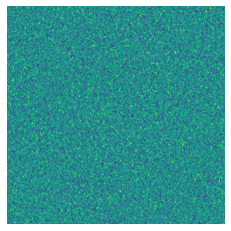

In [3]:
#make movie 
#You can make movies of the mask, the residuals or the image. 
#note to the admins: channel 0 is plotted below the movie. We will fix this later. 

imname = imagename+'.dirty.fits' #name of file your want to make a video from 
svel = 5.1
cmap = 'viridis' #Color map 
window = 20.0 # arcsec extent of the window per channel
nchannels = 132#This is how many channels are plotted. 
movie(imname, nchannels, svel, cmap, window, fitsdata = False) 

HTML('<img src="movie.gif">')

#You can save this gif to your computer! 


## Calculate the Threshold
Now we can find the noise distribution in the data. using imstat (image statistics) we can determine the 1 sigma noise level. We can clean to a multiple of the 1 sigma noise level. If thres in the imputs box is set to 3, then we will be cleaning to 3 sigma. Try changing sigma so you can see how the image changes! 

In [10]:
thres = 4 #sigma

In [11]:
#noise calc here.
def find_noise_beam(imgname,type='line'):
    # get the beam from the dirty image to figure out
    # how the uvtaper should be applied accoring to Loomis' function
    bmax_obs = imhead(imagename=imgname+'.image',mode="get",hdkey="bmaj")['value']
    bmin_obs = imhead(imagename=imgname+'.image',mode="get",hdkey="bmin")['value']
    bpa_obs = imhead(imagename=imgname+'.image',mode="get",hdkey="bpa")['value']#*180/np.pi #radian to deg
   
    noise = imstat(imgname+'.image',chans='1~6')['rms'][0] #estimate noise using the first 6 channels
                                                        # change this if your line appears in these channels
    if abs(bpa_obs) < 5.0:
        bpa_obs = bpa_obs*180.0/np.pi
    else:
        bpa_obs = bpa_obs
    return bmax_obs,bmin_obs,bpa_obs,noise

# Here we run the code to determine the noise level. 
bmax_obs, bmin_obs, bpa_obs, noise = find_noise_beam(imagename+'.dirty',type='line')
print(noise)
#Initially our 'thres' was 3 sigma, we are determining 1 standard deviation of noise and cleaning to 3 times that.
thres = thres*noise
print(thres)

0.0013661533049168096
0.004098459914750429


## Clean the Image
Finally, we can clean the data! 

In [12]:
# Now we clean!!! 
########################
#### tclean Function##### Do Not Change Parameters Here. 
########################  If you want to change them, change them in the Set Parameters Cell. 
# This cell may take between 5 and 30 minutes to run. Go and get a cup of coffee!
tclean(vis=vis,
           imagename=imagename,
           mask= maskname,
           field=field,
           specmode='cube',
           spw=spws,
           restoringbeam='common',
           outframe=outframe,
           interpolation='linear',
           veltype=veltype,
           restfreq=restfreq,
           niter=50000,
           threshold=thres,
           interactive= True,
           cell=cell,
           imsize=imsize,
           weighting=weighting,
           gridder=gridder,
           robust=robustval,
           nchan = nchan,
           width = width,
           start = start
           )

print('Cleaning Done')


Cleaning Done


In [20]:
exportfits(imagename+'.image', fitsimage= imagename+'.fits', dropstokes = True)
exportfits(imagename+'.mask', fitsimage= imagename+'.mask.fits', dropstokes = True)
exportfits(imagename+'.residual', fitsimage = imagename+'.residual.fits', dropstokes = True)

Let's take a look at the cleaned image and its residuals: 

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


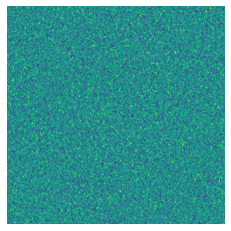

In [4]:
#make movie 
#You can make movies of the mask, the residuals or the image. 
imname = imagename + '.fits' #name of file your want to make a video from 
svel = 5.1
cmap = 'viridis' #Color map 
window = 10.0 # arcsec extent of the window per channel
nchannels = 132#This is how many channels are plotted. 
movie(imname, nchannels, svel, cmap, window, fitsdata = False) 

HTML('<img src="movie.gif">')
#You can save this gif to your computer! 


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


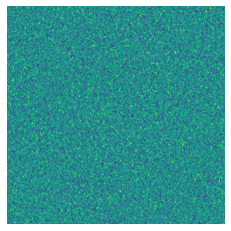

In [5]:
imname = imagename +'.residual.fits' #name of file your want to make a video from 
svel = 5.1
cmap = 'viridis' #Color map 
window = 10.0 # arcsec extent of the window per channel
nchannels = 132#This is how many channels are plotted. 
movie(imname, nchannels, svel, cmap, window, fitsdata = False) 

HTML('<img src="movie.gif">')

## How we display the Cleaned Line Image
### All Channels 

/Users/arw6qz/Desktop/casaguidebetaready-main/plot_all_V2.py:180: UserWarning: No contour levels were found within the data range.
  CSmask = plt.contour(raarr,dearr,pltmask,levels=[1.0],colors='white')


3.349821434202e-05 4.413521568582e-05


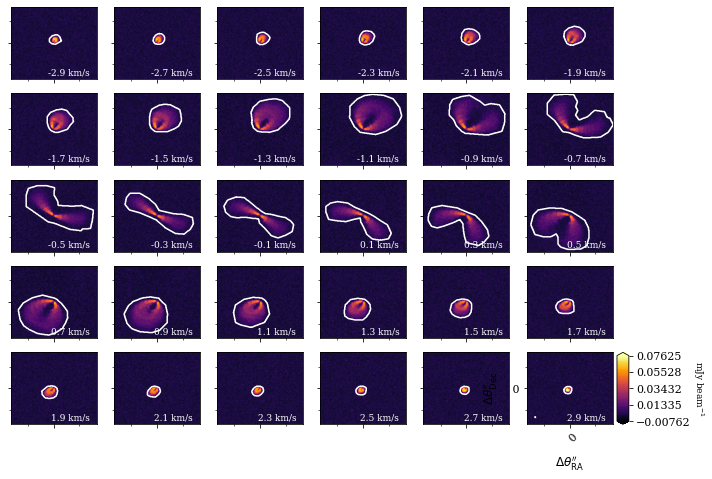

In [21]:
from plot_all_V2 import plotall
import astropy.io.fits as pyfits
imname = imagename + '.fits' # this needs to be a string, so have "" around the file name
maskname = imagename + '.mask.fits'  #Use one of the provided test masks 
svel = 5.1
cmap = 'inferno' #Color map 
window = 5.0 # arcsec extent of the window per channel
ellicol = 'w'
plotall(ellicol, imname, maskname, svel, cmap, window, fitsdata = True, plotMask = True) 

#This takes a while to run (2-3 minutes it seems) 
#plotMask Does not work at the moment. 

### Residuals All Channels
Do plots of residuals so that people can see what unclean, overcleaned, undercleaned, and good clean looks like? Add mask discussion here!!??

/Users/arw6qz/Desktop/casaguidebetaready-main/plot_all_V2.py:180: UserWarning: No contour levels were found within the data range.
  CSmask = plt.contour(raarr,dearr,pltmask,levels=[1.0],colors='white')


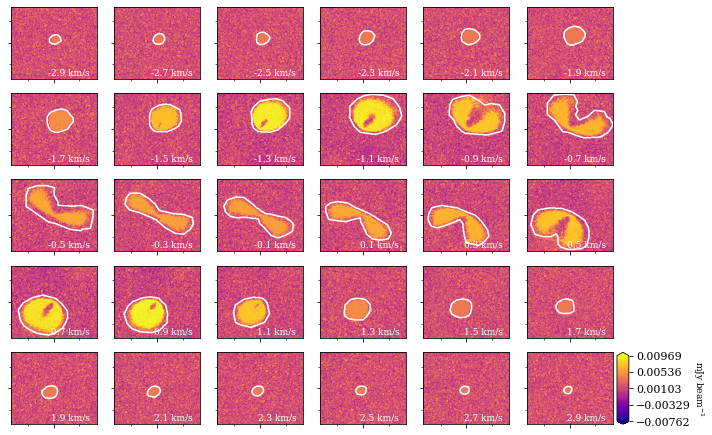

In [8]:
from plot_all_V2 import plotall
imname = imagename+'.residual.fits' # this needs to be a string, so have "" around the file name
maskname = imagename+'.mask.fits'  #Use one of the provided test masks 
svel = 5.1
cmap = 'plasma' #Color map 
window = 5.0 # arcsec extent of the window per channel
ellicol = 'w'
plotall(ellicol, imname, maskname, svel, cmap, window, fitsdata = False, plotMask = True) 

#This takes a while to run (2-3 minutes it seems) 

### Moment Zero Plots
What is a Moment Zero Plot? Collapse the image cube! 


RA and DEC
74.69280441667 29.84346996556
MWC_480_rob_0.5_thres_3.dirty.fits
True
Moment 0 Maps Generated


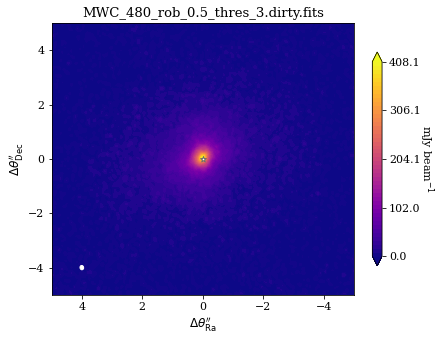

In [10]:
#Plot the Moment 0 Map 
#Works with one or more Files
import newmom0
from newmom0 import mom0
imnames = [imagename+'.dirty.fits'] #Put File you wish to plot here, or list files as strings with commas between. 
svel = 5.1 #km/s
ellipse_color = 'white'
label_color = 'black'
color_map = 'plasma'
window = 5.0

mom0(imnames,svel,color_map,ellipse_color,label_color,window)